In [18]:
import tensorflow as tf
import numpy as np
from modules.models import WavePinn
from modules.data import simulate_wave
from modules.plots import plot_wave_model, plot_training_loss

In [19]:
c = 2
a = 0.5

In [20]:
@tf.function
def u_exact(tx): #phi function
    t = tx[:, 0:1]
    x = tx[:, 1:2]
    return tf.sin(np.pi * x) * tf.cos(c * np.pi * t) + \
            a * tf.sin(2 * c * np.pi* x) * tf.cos(4 * c  * np.pi * t)

@tf.function
def u_t(tx): #psi function
    t = tx[:,0:1]
    x = tx[:,1:2]
    u_t = -  c * np.pi * tf.sin(np.pi * x) * tf.sin(c * np.pi * t) - \
            a * 4 * c * np.pi * tf.sin(2 * c * np.pi* x) * tf.sin(4 * c * np.pi * t)
    return u_t

In [21]:
(tx_eqn, residual), (tx_init, phi_init, psi_init), (tx_bndry, u_bndry) = simulate_wave(2000, phi_function=u_exact, psi_function=u_t, boundary_function=u_exact, dtype=tf.float32)

In [22]:
inputs = tf.stack([tx_eqn, tx_init, tx_bndry], axis=0)
outputs = tf.stack([phi_init, psi_init, u_bndry], axis=0)

In [26]:
network = WavePinn.build_network([32, 64, 128])
model = WavePinn(network, c=c)
model.compile()

In [27]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [28]:
history = model.fit(inputs, outputs, epochs=5000, optimizer=optimizer, progress_interval=200)

Epoch: 0 Loss: 0.7695 Total Elapsed Time: 1.71
Epoch: 200 Loss: 0.3211 Total Elapsed Time: 6.31
Epoch: 400 Loss: 0.2928 Total Elapsed Time: 11.19
Epoch: 600 Loss: 0.2185 Total Elapsed Time: 16.02
Epoch: 800 Loss: 0.1495 Total Elapsed Time: 20.89
Epoch: 1000 Loss: 0.1427 Total Elapsed Time: 25.92
Epoch: 1200 Loss: 0.1401 Total Elapsed Time: 31.06
Epoch: 1400 Loss: 0.1351 Total Elapsed Time: 36.47
Epoch: 1600 Loss: 0.1474 Total Elapsed Time: 41.66
Epoch: 1800 Loss: 0.1286 Total Elapsed Time: 46.77
Epoch: 2000 Loss: 0.1332 Total Elapsed Time: 51.94
Epoch: 2200 Loss: 0.1215 Total Elapsed Time: 56.58
Epoch: 2400 Loss: 0.1186 Total Elapsed Time: 61.18
Epoch: 2600 Loss: 0.1164 Total Elapsed Time: 65.72
Epoch: 2800 Loss: 0.1121 Total Elapsed Time: 70.22
Epoch: 3000 Loss: 0.1298 Total Elapsed Time: 74.89
Epoch: 3200 Loss: 0.1038 Total Elapsed Time: 79.47
Epoch: 3400 Loss: 0.0999 Total Elapsed Time: 84.34
Epoch: 3600 Loss: 0.1095 Total Elapsed Time: 89.42
Epoch: 3800 Loss: 0.1066 Total Elapsed T

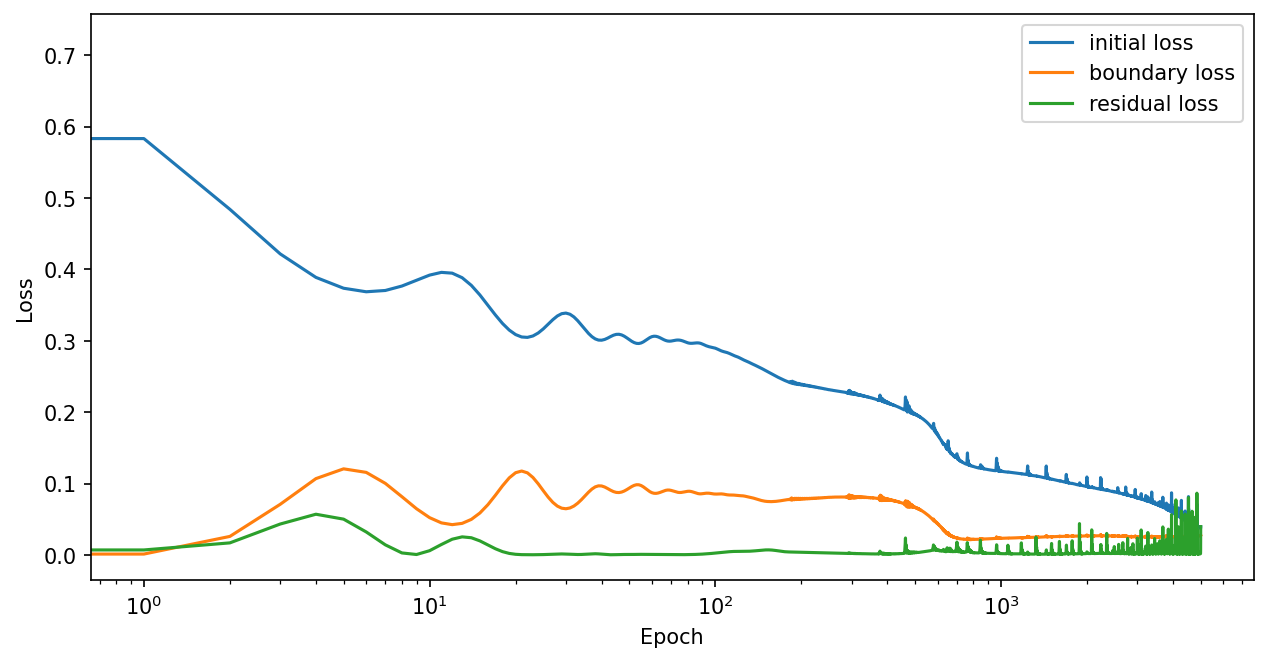

In [29]:
plot_training_loss(history, 'log')

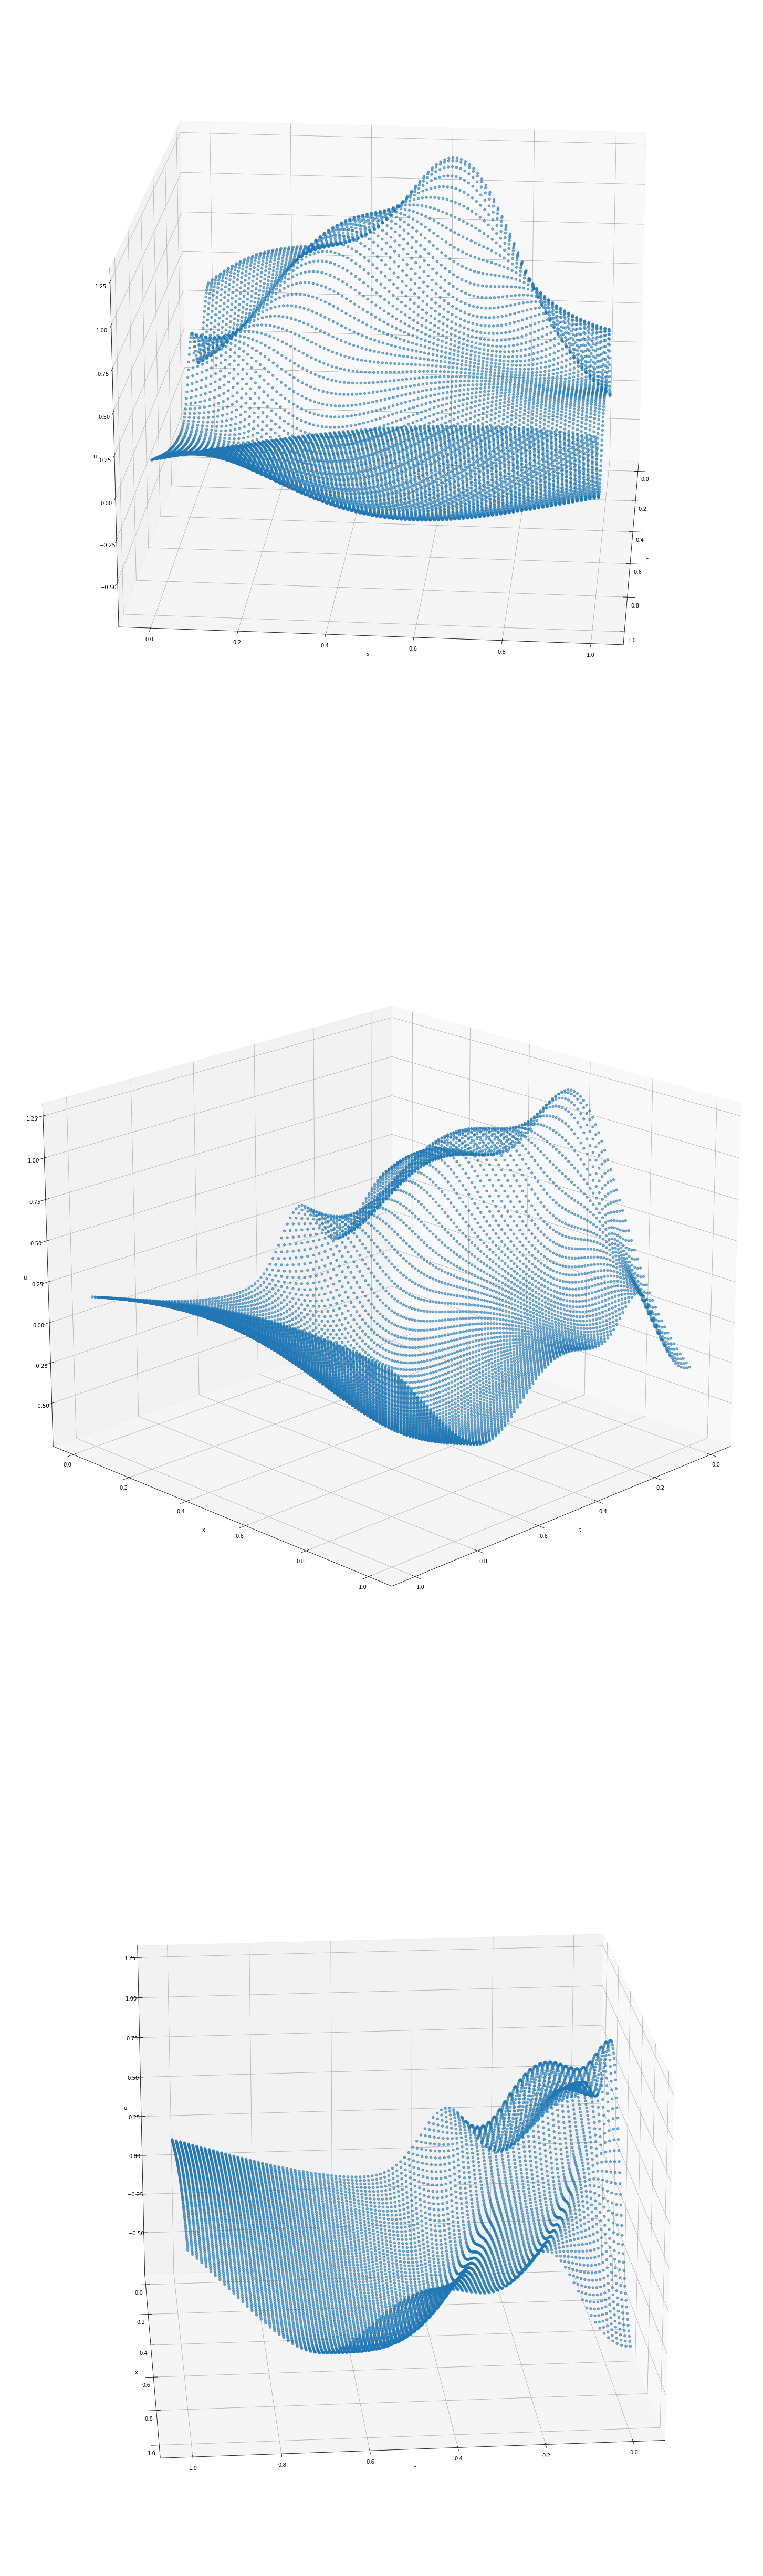

In [30]:
plot_wave_model(model.network, 0, 1, 1, False)